#EVALUATING DATA FOR MULTIPLE DATASETS to fit NuScene format for Trajectron++


## Mount the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install necessary requirements for evaluation

In [1]:
%cd /content/drive/My Drive/Colab Notebooks/Trajectron++
!pip install -r requirements.txt

/content/drive/My Drive/Colab Notebooks/Trajectron++


## Process the data

In [2]:
%cd /content/drive/My Drive/Colab Notebooks/Trajectron++/experiments/MAVRIC

/content/drive/My Drive/Colab Notebooks/Trajectron++/experiments/MAVRIC


In [3]:
import sys
import os
import dill
import json
import argparse
import torch
import numpy as np
import pandas as pd
import pdb
sys.path.append("../../trajectron")
from tqdm import tqdm
from model.model_registrar import ModelRegistrar
from model.trajectron import Trajectron
import evaluation
import utils
from scipy.interpolate import RectBivariateSpline
from utils import prediction_output_to_trajectories

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

def batch_statistics(prediction_output_dict,
                             dt,
                             max_hl,
                             ph,
                             node_type_enum,
                             kde=True,
                             obs=False,
                             map=None,
                             prune_ph_to_future=False,
                             best_of=False):
    (prediction_dict,
     _,
     futures_dict) = prediction_output_to_trajectories(prediction_output_dict,
                                                       dt,
                                                       max_hl,
                                                       ph,
                                                       prune_ph_to_future=prune_ph_to_future)
    return prediction_dict, futures_dict

def load_model(model_dir, env, ts=100):
    model_registrar = ModelRegistrar(model_dir, 'cpu')
    model_registrar.load_models(ts)
    with open(os.path.join(model_dir, 'config.json'), 'r') as config_json:
        hyperparams = json.load(config_json)

    trajectron = Trajectron(model_registrar, hyperparams, None, 'cpu')

    trajectron.set_environment(env)
    trajectron.set_annealing_params()
    return trajectron, hyperparams

def print_scene(data):
  with open(data, 'rb') as f:
    env = dill.load(f, encoding='latin1')
  scenes = env.scenes
  for scene in scenes:
    # pdb.set_trace()
    print(scene.name + " " + str(scene))
  

def plot_trajectories(model, checkpoint, data, node_type,prediction_horizon):
  with open(data, 'rb') as f:
    env = dill.load(f, encoding='latin1')

  eval_stg, hyperparams = load_model(model, env, ts=checkpoint)

  if 'override_attention_radius' in hyperparams:
      for attention_radius_override in hyperparams['override_attention_radius']:
          node_type1, node_type2, attention_radius = attention_radius_override.split(' ')
          env.attention_radius[(node_type1, node_type2)] = float(attention_radius)

  scenes = env.scenes

  print("-- Preparing Node Graph")
  for scene in tqdm(scenes):
    # pdb.set_trace()
    scene.calculate_scene_graph(env.attention_radius,
                                  hyperparams['edge_addition_filter'],
                                  hyperparams['edge_removal_filter'])

  for ph in [prediction_horizon]:
    print(f"Prediction Horizon: {ph}")
    max_hl = hyperparams['maximum_history_length']

    with torch.no_grad():
        ############### MOST LIKELY Z ###############
        print("-- Evaluating GMM Z Mode (Most Likely)")
        scene_dict = {}
        scene_gt_dict = {}
        for scene in tqdm(scenes):
            timesteps = np.arange(scene.timesteps)

            predictions = eval_stg.predict(scene,
                                            timesteps,
                                            ph,
                                            num_samples=1,
                                            # min_future_timesteps=2,
                                            min_future_timesteps=8,
                                            z_mode=True,
                                            gmm_mode=True,
                                            full_dist=False)  # This will trigger grid sampling
            # print(scene)
            predict_dict, futures_dict = batch_statistics(predictions,
                                                                       scene.dt,
                                                                       max_hl=max_hl,
                                                                       ph=ph,
                                                                       node_type_enum=env.NodeType,
                                                                       map=None,
                                                                       prune_ph_to_future=False,
                                                                       kde=False)
            # pdb.set_trace()
            # node_dict = {}
            # node_gt_dict = {}
            # for node in scene.nodes:
            #   predict = np.empty((0,2))
            #   # pdb.set_trace()
            #   if (node.type.name == node_type):
            #     for key in predictions.keys():
            #         try:
            #             predict = np.append(predict, predictions[key][node].reshape(predictions[key][node].shape[2],predictions[key][node].shape[3]), axis=0)
            #         except:
            #             pass
            #     node_dict[node.id] = predict
            #     node_gt_dict[node.id] = node.data.data
            # scene_dict[scene.name] = node_dict
            # scene_gt_dict[scene.name] = node_gt_dict
            node_dict = {}
            node_gt_dict = {}
            for node in scene.nodes:
              predict = np.empty((0,2))
              futures = np.empty((0,2))
              if (node.type.name == node_type):
                # pdb.set_trace()
                for key in predict_dict.keys():
                    try:
                        # pdb.set_trace()
                        predict = np.append(predict, predict_dict[key][node].reshape(predict_dict[key][node].shape[2],predict_dict[key][node].shape[3]), axis=0)
                        futures = np.append(futures, futures_dict[key][node], axis=0)
                    except:
                        pass
                node_dict[node.id] = predict
                node_gt_dict[node.id] = futures
                # node_gt_dict[node.id] = node.data.data[:,0:2]
            scene_dict[scene.name] = node_dict
            scene_gt_dict[scene.name] = node_gt_dict

        # pdb.set_trace()
  return scene_dict, scene_gt_dict
        ############### FULL ###############
        # print("-- Evaluating Full")
        # for scene in tqdm(scenes):
        #     timesteps = np.arange(scene.timesteps)
        #     pdb.set_trace()
        #     predictions = eval_stg.predict(scene,
        #                                     timesteps,
        #                                     ph,
        #                                     num_samples=2000,
        #                                     min_future_timesteps=8,
        #                                     z_mode=False,
        #                                     gmm_mode=False,
        #                                     full_dist=False)

        #     if not predictions:
        #         continue

        #     prediction_dict, _, _ = utils.prediction_output_to_trajectories(predictions,
        #                                                                     scene.dt,
        #                                                                     max_hl,
        #                                                                     ph,
        #                                                                     prune_ph_to_future=False)

### NuScenes (Done)
num_samples = 20

In [ ]:
print_scene('./data/processed/nuScenes/nuScenes_01_full.pkl')

0 Scene: Duration: 20.0s, Nodes: 1, Map: No.
1 Scene: Duration: 20.0s, Nodes: 18, Map: No.
2 Scene: Duration: 20.0s, Nodes: 20, Map: No.
3 Scene: Duration: 20.0s, Nodes: 11, Map: No.
4 Scene: Duration: 19.5s, Nodes: 8, Map: No.
5 Scene: Duration: 20.0s, Nodes: 4, Map: No.
6 Scene: Duration: 19.5s, Nodes: 25, Map: No.
7 Scene: Duration: 20.0s, Nodes: 25, Map: No.
8 Scene: Duration: 20.0s, Nodes: 10, Map: No.
9 Scene: Duration: 20.0s, Nodes: 9, Map: No.
10 Scene: Duration: 20.0s, Nodes: 2, Map: No.
11 Scene: Duration: 20.0s, Nodes: 4, Map: No.
12 Scene: Duration: 20.0s, Nodes: 16, Map: No.
13 Scene: Duration: 20.0s, Nodes: 6, Map: No.
14 Scene: Duration: 20.0s, Nodes: 14, Map: No.
15 Scene: Duration: 20.0s, Nodes: 45, Map: No.
16 Scene: Duration: 20.0s, Nodes: 51, Map: No.
17 Scene: Duration: 20.0s, Nodes: 28, Map: No.
18 Scene: Duration: 20.0s, Nodes: 35, Map: No.
19 Scene: Duration: 19.5s, Nodes: 12, Map: No.
20 Scene: Duration: 20.0s, Nodes: 18, Map: No.
21 Scene: Duration: 20.0s, Nod

In [4]:
data_nu_2, data_gt_nu_2 = plot_trajectories('models/vel_ee', 12, './data/processed/nuScenes/nuScenes_01_full.pkl', 'PEDESTRIAN', 2)


Loading from models/vel_ee/model_registrar-12.pt
Loaded!



 20%|██        | 17/85 [00:00<00:00, 127.08it/s]

-- Preparing Node Graph


  2%|▏         | 2/85 [00:00<00:05, 15.11it/s]

Prediction Horizon: 2
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 85/85 [00:27<00:00,  3.14it/s]


In [5]:
data_nu_2.keys()
for key in data_nu_2.keys():
  print(key + ' ' + str(data_nu_2[key].keys()))

0 dict_keys([])
1 dict_keys([])
2 dict_keys([])
3 dict_keys(['19', '20', '22', '23', '21', '24', '25', '26', '27', '28'])
4 dict_keys([])
5 dict_keys(['14', '13', '15'])
6 dict_keys(['6', '7', '8', '10', '9', '11', '13', '12', '15', '14', '16', '17', '18', '19', '20', '21', '22', '24', '23', '25', '27', '26', '28', '29'])
7 dict_keys(['10', '9', '8', '7', '5', '6', '13', '12', '11', '14', '17', '16', '15', '19', '18', '20', '21', '22', '24', '23', '25', '27', '26', '28'])
8 dict_keys(['10', '15', '14', '16', '17', '18', '20', '19', '21'])
9 dict_keys([])
10 dict_keys(['15'])
11 dict_keys([])
12 dict_keys([])
13 dict_keys([])
14 dict_keys([])
15 dict_keys(['10', '9', '8', '7', '6', '5', '13', '12', '11', '15', '14', '17', '19', '18', '23', '22', '20', '21', '24', '25', '27', '28', '26', '29', '34', '30', '36', '35', '37', '38', '39', '41', '42', '40', '45', '44', '43', '46', '47', '48', '49', '50', '52', '51'])
16 dict_keys(['4', '15', '18', '21', '20', '19', '25', '27', '26', '23', '24

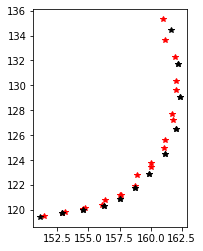

(22,)
(22,)


In [12]:
import matplotlib.pyplot as plt
data = data_nu_2['58']['51']
data_gt = data_gt_nu_2['58']['51']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()
print(data[:,0].shape)
print(data_gt[:,0].shape)

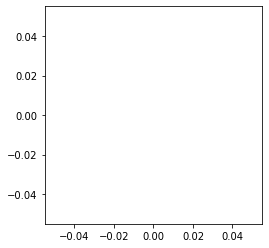

8(0, 2)
8(0, 2)


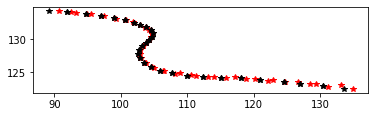

5(60, 2)
5(60, 2)


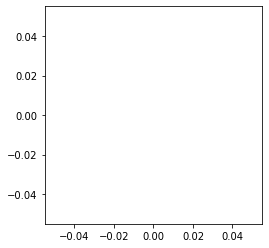

7(0, 2)
7(0, 2)


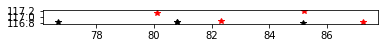

4(4, 2)
4(4, 2)


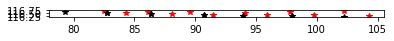

3(12, 2)
3(12, 2)


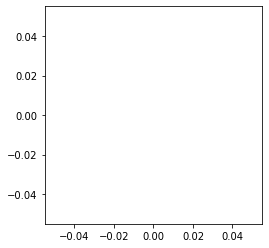

9(0, 2)
9(0, 2)


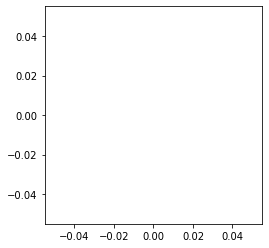

11(0, 2)
11(0, 2)


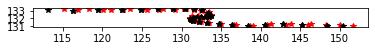

10(58, 2)
10(58, 2)


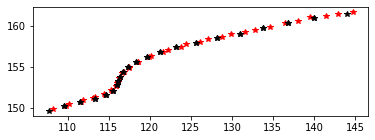

12(42, 2)
12(42, 2)


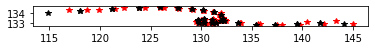

13(52, 2)
13(52, 2)


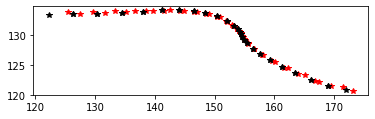

15(50, 2)
15(50, 2)


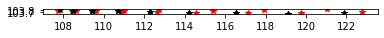

14(16, 2)
14(16, 2)


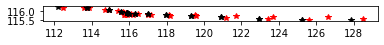

16(32, 2)
16(32, 2)


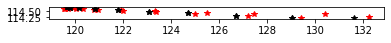

17(22, 2)
17(22, 2)


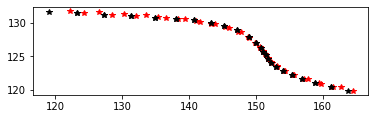

21(46, 2)
21(46, 2)


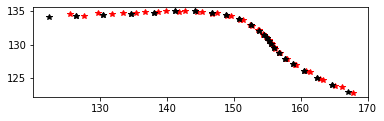

20(46, 2)
20(46, 2)


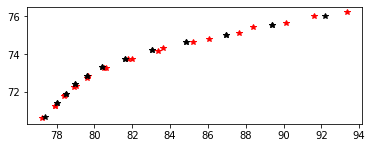

19(22, 2)
19(22, 2)


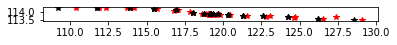

18(36, 2)
18(36, 2)


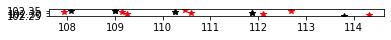

22(8, 2)
22(8, 2)


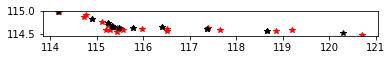

23(22, 2)
23(22, 2)


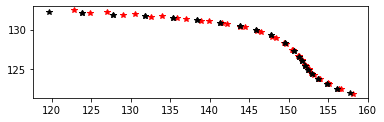

24(40, 2)
24(40, 2)


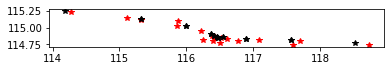

25(20, 2)
25(20, 2)


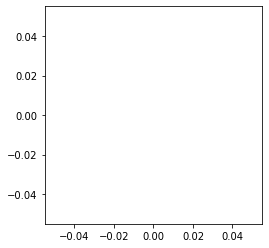

27(0, 2)
27(0, 2)


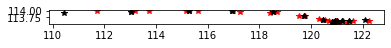

26(26, 2)
26(26, 2)


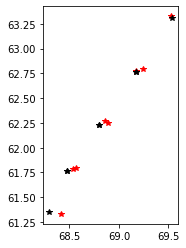

29(8, 2)
29(8, 2)


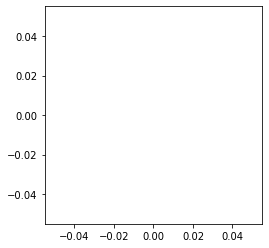

30(0, 2)
30(0, 2)


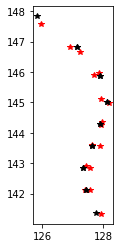

28(16, 2)
28(16, 2)


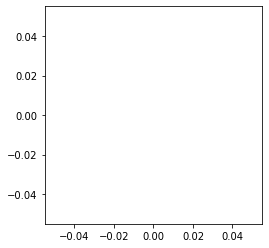

31(0, 2)
31(0, 2)


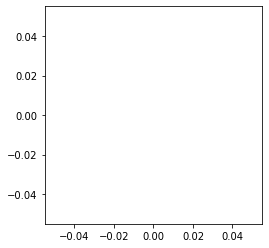

32(0, 2)
32(0, 2)


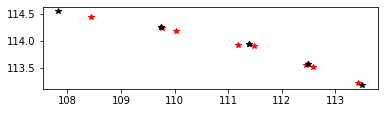

33(8, 2)
33(8, 2)


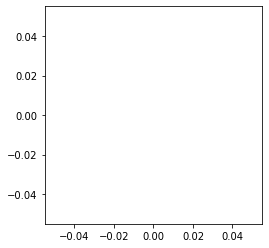

34(0, 2)
34(0, 2)


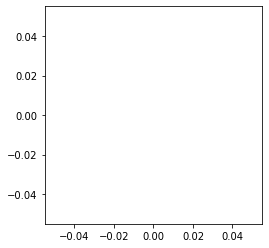

35(0, 2)
35(0, 2)


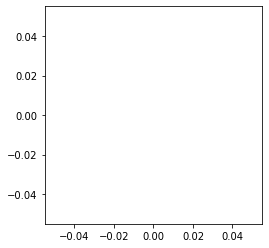

37(0, 2)
37(0, 2)


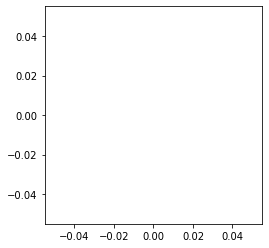

36(0, 2)
36(0, 2)


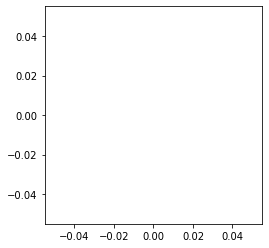

40(0, 2)
40(0, 2)


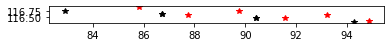

38(6, 2)
38(6, 2)


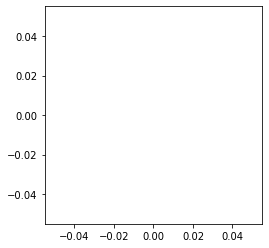

39(0, 2)
39(0, 2)


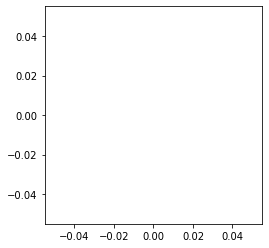

42(0, 2)
42(0, 2)


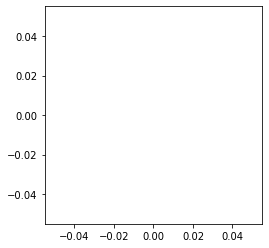

44(0, 2)
44(0, 2)


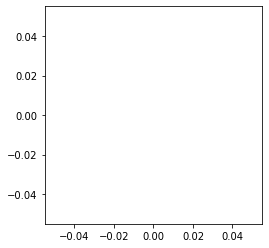

43(0, 2)
43(0, 2)


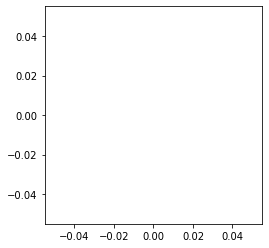

45(0, 2)
45(0, 2)


In [8]:
import matplotlib.pyplot as plt
scene = '23'
for key in data_nu_2[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_nu_2[scene][key]
  data_gt = data_gt_nu_2[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


In [9]:
data_nu_4, data_gt_nu_4 = plot_trajectories('models/vel_ee', 12, './data/processed/nuScenes/nuScenes_01_full.pkl', 'PEDESTRIAN', 4)

 20%|██        | 17/85 [00:00<00:00, 129.89it/s]


Loading from models/vel_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  2%|▏         | 2/85 [00:00<00:05, 13.88it/s]

Prediction Horizon: 4
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 85/85 [00:27<00:00,  3.06it/s]


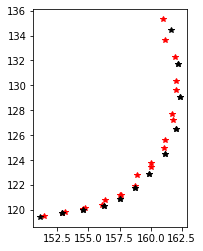

(22,)
(22,)


In [13]:
import matplotlib.pyplot as plt
data = data_nu_2['58']['51']
data_gt = data_gt_nu_2['58']['51']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()
print(data[:,0].shape)
print(data_gt[:,0].shape)

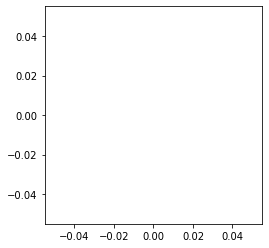

8(0, 2)
8(0, 2)


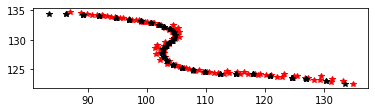

5(120, 2)
5(120, 2)


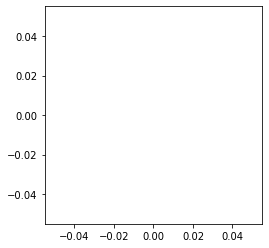

7(0, 2)
7(0, 2)


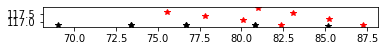

4(8, 2)
4(8, 2)


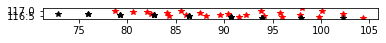

3(24, 2)
3(24, 2)


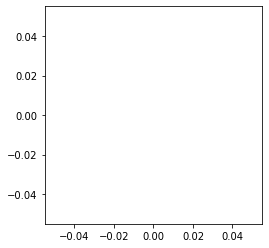

9(0, 2)
9(0, 2)


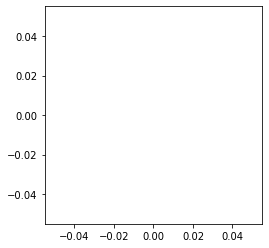

11(0, 2)
11(0, 2)


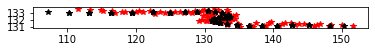

10(116, 2)
10(116, 2)


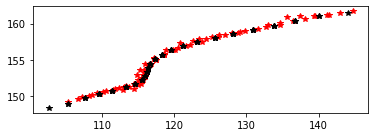

12(84, 2)
12(84, 2)


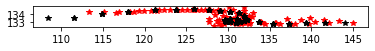

13(104, 2)
13(104, 2)


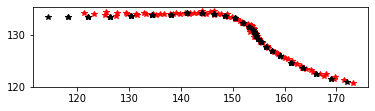

15(100, 2)
15(100, 2)


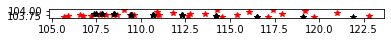

14(32, 2)
14(32, 2)


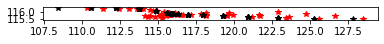

16(64, 2)
16(64, 2)


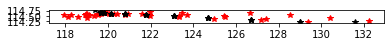

17(44, 2)
17(44, 2)


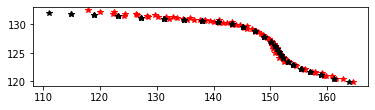

21(92, 2)
21(92, 2)


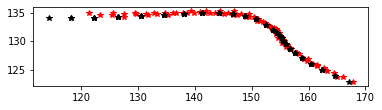

20(92, 2)
20(92, 2)


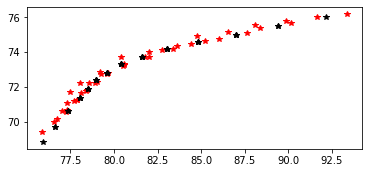

19(44, 2)
19(44, 2)


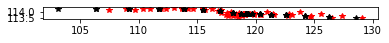

18(72, 2)
18(72, 2)


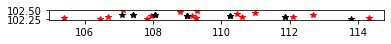

22(16, 2)
22(16, 2)


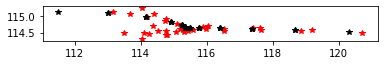

23(44, 2)
23(44, 2)


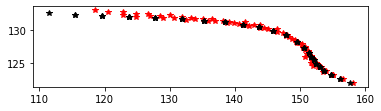

24(80, 2)
24(80, 2)


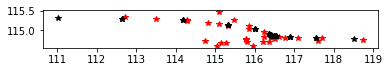

25(40, 2)
25(40, 2)


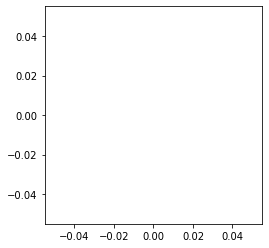

27(0, 2)
27(0, 2)


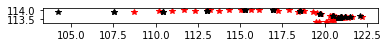

26(52, 2)
26(52, 2)


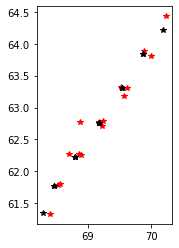

29(16, 2)
29(16, 2)


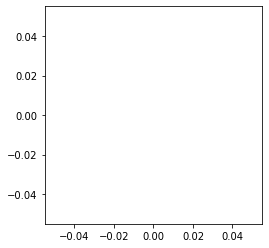

30(0, 2)
30(0, 2)


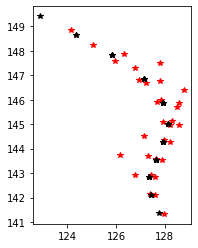

28(32, 2)
28(32, 2)


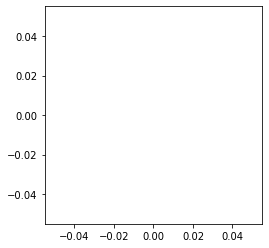

31(0, 2)
31(0, 2)


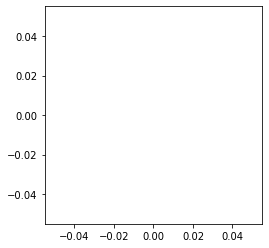

32(0, 2)
32(0, 2)


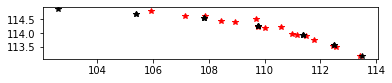

33(16, 2)
33(16, 2)


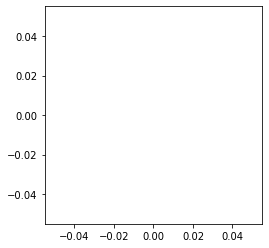

34(0, 2)
34(0, 2)


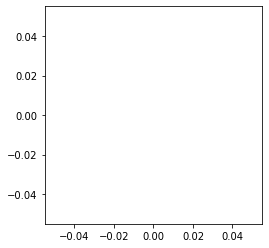

35(0, 2)
35(0, 2)


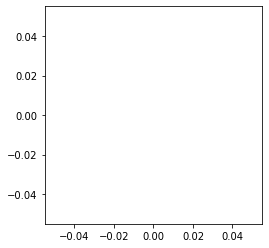

37(0, 2)
37(0, 2)


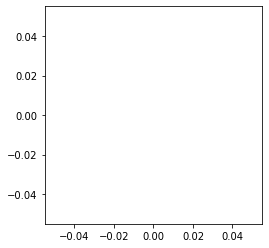

36(0, 2)
36(0, 2)


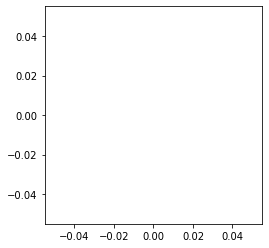

40(0, 2)
40(0, 2)


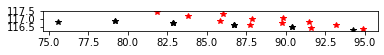

38(12, 2)
38(12, 2)


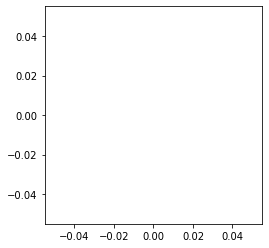

39(0, 2)
39(0, 2)


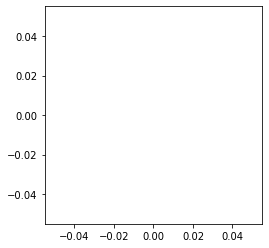

42(0, 2)
42(0, 2)


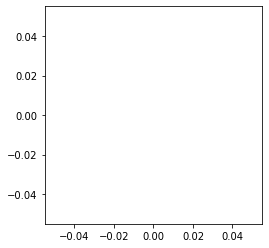

44(0, 2)
44(0, 2)


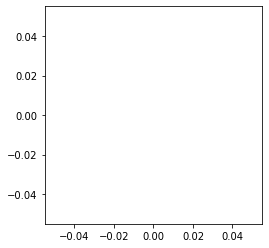

43(0, 2)
43(0, 2)


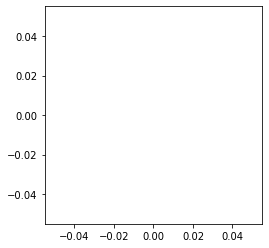

45(0, 2)
45(0, 2)


In [14]:
import matplotlib.pyplot as plt
scene = '23'
for key in data_nu_4[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_nu_4[scene][key]
  data_gt = data_gt_nu_4[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


In [15]:
data_nu_6, data_gt_nu_6 = plot_trajectories('models/vel_ee', 12, './data/processed/nuScenes/nuScenes_01_full.pkl', 'PEDESTRIAN', 6)

 20%|██        | 17/85 [00:00<00:00, 130.22it/s]


Loading from models/vel_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  2%|▏         | 2/85 [00:00<00:05, 13.86it/s]

Prediction Horizon: 6
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 85/85 [00:27<00:00,  3.05it/s]


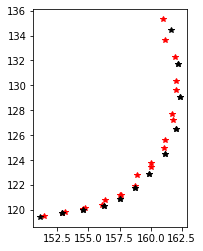

(22,)
(22,)


In [16]:
import matplotlib.pyplot as plt
data = data_nu_2['58']['51']
data_gt = data_gt_nu_2['58']['51']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()
print(data[:,0].shape)
print(data_gt[:,0].shape)

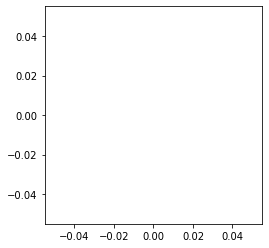

8(0, 2)
8(0, 2)


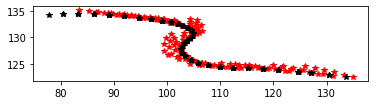

5(180, 2)
5(180, 2)


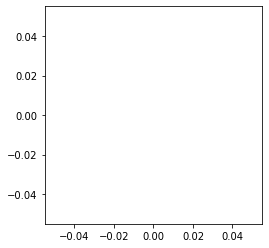

7(0, 2)
7(0, 2)


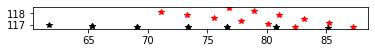

4(12, 2)
4(12, 2)


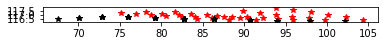

3(36, 2)
3(36, 2)


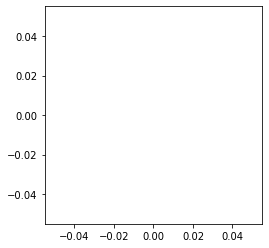

9(0, 2)
9(0, 2)


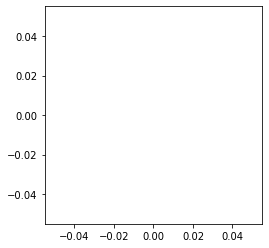

11(0, 2)
11(0, 2)


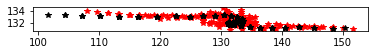

10(174, 2)
10(174, 2)


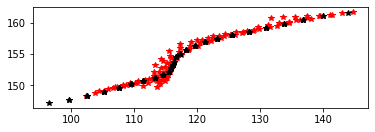

12(126, 2)
12(126, 2)


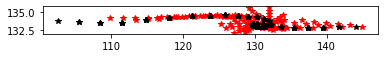

13(156, 2)
13(156, 2)


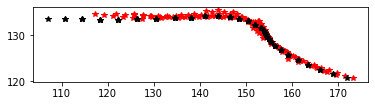

15(150, 2)
15(150, 2)


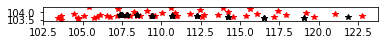

14(48, 2)
14(48, 2)


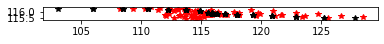

16(96, 2)
16(96, 2)


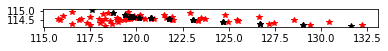

17(66, 2)
17(66, 2)


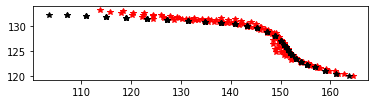

21(138, 2)
21(138, 2)


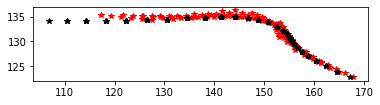

20(138, 2)
20(138, 2)


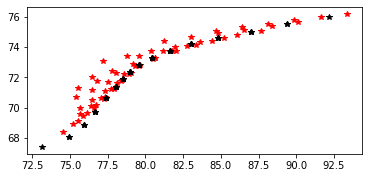

19(66, 2)
19(66, 2)


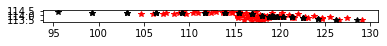

18(108, 2)
18(108, 2)


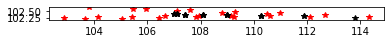

22(24, 2)
22(24, 2)


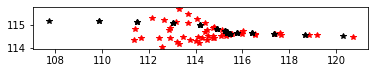

23(66, 2)
23(66, 2)


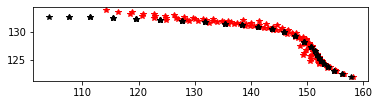

24(120, 2)
24(120, 2)


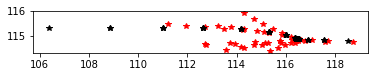

25(60, 2)
25(60, 2)


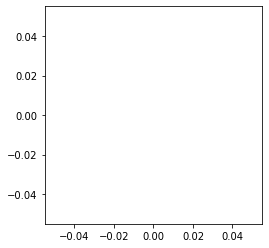

27(0, 2)
27(0, 2)


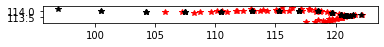

26(78, 2)
26(78, 2)


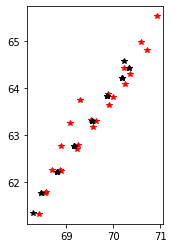

29(24, 2)
29(24, 2)


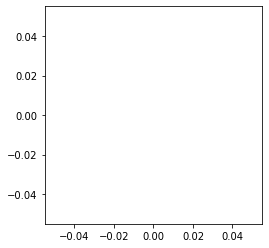

30(0, 2)
30(0, 2)


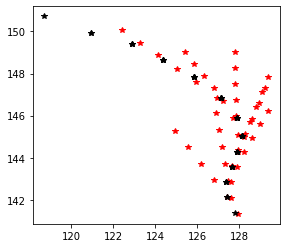

28(48, 2)
28(48, 2)


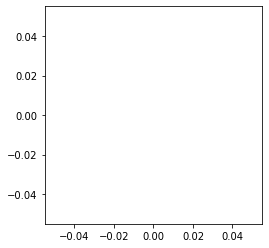

31(0, 2)
31(0, 2)


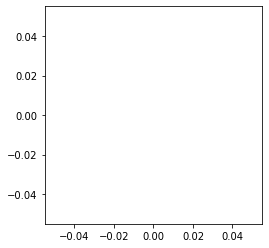

32(0, 2)
32(0, 2)


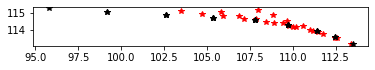

33(24, 2)
33(24, 2)


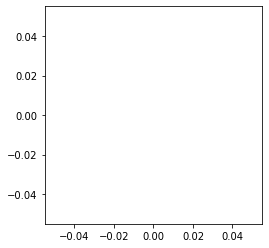

34(0, 2)
34(0, 2)


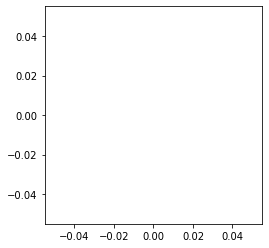

35(0, 2)
35(0, 2)


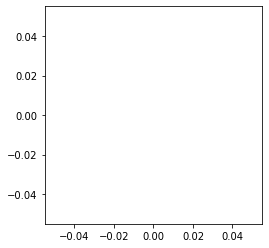

37(0, 2)
37(0, 2)


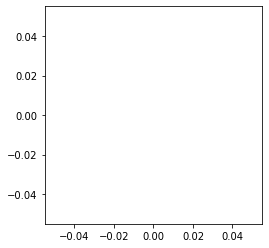

36(0, 2)
36(0, 2)


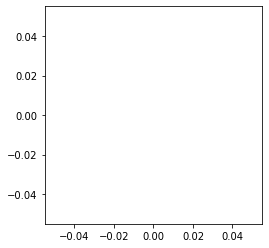

40(0, 2)
40(0, 2)


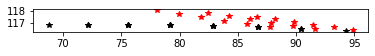

38(18, 2)
38(18, 2)


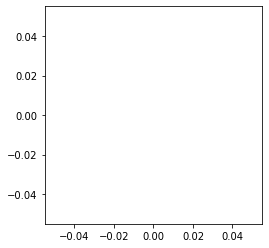

39(0, 2)
39(0, 2)


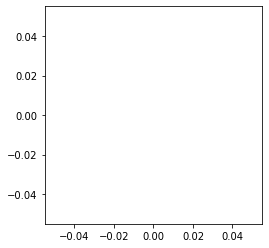

42(0, 2)
42(0, 2)


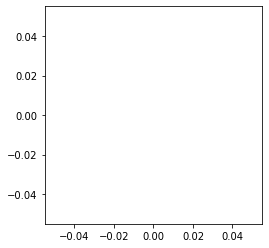

44(0, 2)
44(0, 2)


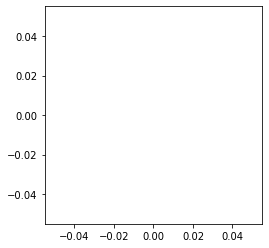

43(0, 2)
43(0, 2)


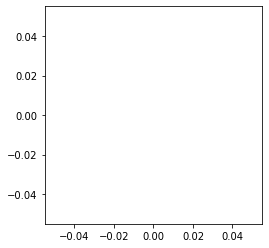

45(0, 2)
45(0, 2)


In [17]:
import matplotlib.pyplot as plt
scene = '23'
for key in data_nu_6[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_nu_6[scene][key]
  data_gt = data_gt_nu_6[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


### Lyft (Done)

In [18]:
print_scene('./data/processed/Lyft/Lyft_1_full.pkl')

1513 Scene: Duration: 25.200000000000003s, Nodes: 44, Map: No.
1514 Scene: Duration: 25.200000000000003s, Nodes: 25, Map: No.
1515 Scene: Duration: 25.200000000000003s, Nodes: 73, Map: No.
1516 Scene: Duration: 25.200000000000003s, Nodes: 53, Map: No.
1517 Scene: Duration: 25.200000000000003s, Nodes: 20, Map: No.
1518 Scene: Duration: 25.200000000000003s, Nodes: 4, Map: No.
1519 Scene: Duration: 25.200000000000003s, Nodes: 84, Map: No.
1520 Scene: Duration: 25.200000000000003s, Nodes: 42, Map: No.
1521 Scene: Duration: 25.200000000000003s, Nodes: 8, Map: No.
1522 Scene: Duration: 25.200000000000003s, Nodes: 36, Map: No.
1523 Scene: Duration: 25.200000000000003s, Nodes: 22, Map: No.
1524 Scene: Duration: 25.200000000000003s, Nodes: 14, Map: No.
1525 Scene: Duration: 25.200000000000003s, Nodes: 41, Map: No.
1526 Scene: Duration: 25.200000000000003s, Nodes: 5, Map: No.
1527 Scene: Duration: 25.200000000000003s, Nodes: 43, Map: No.
1528 Scene: Duration: 25.200000000000003s, Nodes: 22, Map:

In [24]:
data_lyft_2, data_gt_lyft_2 = plot_trajectories('models/vel_ee', 12, './data/processed/Lyft/Lyft_1_full.pkl', 'PEDESTRIAN', 2)

  0%|          | 0/90 [00:00<?, ?it/s]


Loading from models/vel_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/90 [00:00<?, ?it/s]

Prediction Horizon: 2
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 90/90 [01:26<00:00,  1.04it/s]


In [25]:
data_lyft_2.keys()
for key in data_lyft_2.keys():
  print(key + ' ' + str(data_lyft_2[key].keys()))

1513 dict_keys([])
1514 dict_keys([])
1515 dict_keys([])
1516 dict_keys([])
1517 dict_keys([])
1518 dict_keys([])
1519 dict_keys([])
1520 dict_keys([])
1521 dict_keys([])
1522 dict_keys([])
1523 dict_keys([])
1524 dict_keys([])
1525 dict_keys([])
1526 dict_keys([])
1527 dict_keys([])
1528 dict_keys([])
1529 dict_keys([])
1530 dict_keys([])
1531 dict_keys([])
1532 dict_keys([])
1533 dict_keys([])
1534 dict_keys([])
1535 dict_keys([])
1536 dict_keys([])
1537 dict_keys([])
1538 dict_keys([])
1539 dict_keys([])
1540 dict_keys([])
1541 dict_keys([])
1542 dict_keys([])
1543 dict_keys([])
1544 dict_keys([])
1545 dict_keys([])
1546 dict_keys([])
1547 dict_keys([])
1548 dict_keys([])
1549 dict_keys([])
1550 dict_keys([])
1551 dict_keys([])
1552 dict_keys([])
1553 dict_keys([])
1554 dict_keys([])
1555 dict_keys([])
1556 dict_keys([])
1557 dict_keys([])
1558 dict_keys([])
1559 dict_keys([])
1560 dict_keys([])
1561 dict_keys([])
1562 dict_keys([])
1563 dict_keys([])
1564 dict_keys([])
1565 dict_ke

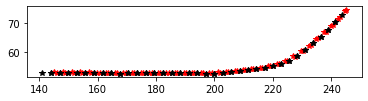

(72,)
(72,)


In [26]:
import matplotlib.pyplot as plt
data = data_lyft_2['1593']['6']
data_gt = data_gt_lyft_2['1593']['6']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()
print(data[:,0].shape)
print(data_gt[:,0].shape)

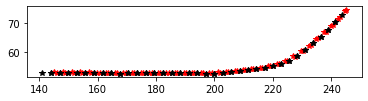

(72, 2)
(72, 2)


In [27]:
import matplotlib.pyplot as plt
scene = '1593'
for key in data_lyft_2[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_lyft_2[scene][key]
  data_gt = data_gt_lyft_2[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(data.shape)
  print(data_gt.shape)


In [28]:
data_lyft_4, data_gt_lyft_4 = plot_trajectories('models/vel_ee', 12, './data/processed/Lyft/Lyft_1_full.pkl', 'PEDESTRIAN', 4)

  0%|          | 0/90 [00:00<?, ?it/s]


Loading from models/vel_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/90 [00:00<?, ?it/s]

Prediction Horizon: 4
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 90/90 [01:28<00:00,  1.02it/s]


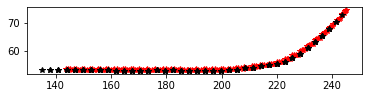

(144,)
(144,)


In [29]:
import matplotlib.pyplot as plt
data = data_lyft_4['1593']['6']
data_gt = data_gt_lyft_4['1593']['6']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()
print(data[:,0].shape)
print(data_gt[:,0].shape)

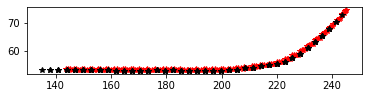

(144, 2)
(144, 2)


In [30]:
import matplotlib.pyplot as plt
scene = '1593'
for key in data_lyft_4[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_lyft_4[scene][key]
  data_gt = data_gt_lyft_4[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(data.shape)
  print(data_gt.shape)


In [31]:
data_lyft_6, data_gt_lyft_6 = plot_trajectories('models/vel_ee', 12, './data/processed/Lyft/Lyft_1_full.pkl', 'PEDESTRIAN', 6)

  0%|          | 0/90 [00:00<?, ?it/s]


Loading from models/vel_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/90 [00:00<?, ?it/s]

Prediction Horizon: 6
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 90/90 [01:28<00:00,  1.02it/s]


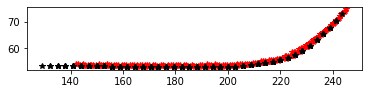

(216,)
(216,)


In [32]:
import matplotlib.pyplot as plt
data = data_lyft_6['1593']['6']
data_gt = data_gt_lyft_6['1593']['6']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()
print(data[:,0].shape)
print(data_gt[:,0].shape)

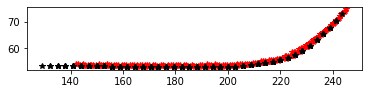

(216, 2)
(216, 2)


In [33]:
import matplotlib.pyplot as plt
scene = '1593'
for key in data_lyft_6[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_lyft_6[scene][key]
  data_gt = data_gt_lyft_6[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(data.shape)
  print(data_gt.shape)


### Argo (Done)

In [34]:
print_scene('./data/processed/Argoverse/Argoverse_1_full.pkl')

1448 Scene: Duration: 31.400000000000002s, Nodes: 25, Map: No.
1449 Scene: Duration: 60.0s, Nodes: 13, Map: No.
1450 Scene: Duration: 31.200000000000003s, Nodes: 22, Map: No.
1451 Scene: Duration: 57.800000000000004s, Nodes: 27, Map: No.
1452 Scene: Duration: 31.400000000000002s, Nodes: 20, Map: No.
1453 Scene: Duration: 29.400000000000002s, Nodes: 10, Map: No.
1454 Scene: Duration: 31.400000000000002s, Nodes: 30, Map: No.
1455 Scene: Duration: 29.200000000000003s, Nodes: 16, Map: No.
1456 Scene: Duration: 31.200000000000003s, Nodes: 17, Map: No.
1457 Scene: Duration: 31.0s, Nodes: 27, Map: No.
1458 Scene: Duration: 30.8s, Nodes: 11, Map: No.
1459 Scene: Duration: 58.6s, Nodes: 29, Map: No.
1460 Scene: Duration: 58.400000000000006s, Nodes: 10, Map: No.
1461 Scene: Duration: 31.400000000000002s, Nodes: 36, Map: No.
1462 Scene: Duration: 59.800000000000004s, Nodes: 11, Map: No.
1463 Scene: Duration: 31.200000000000003s, Nodes: 19, Map: No.
1464 Scene: Duration: 31.200000000000003s, Nodes

In [35]:
data_argo_2, data_gt_argo_2 = plot_trajectories('models/vel_ee', 12, './data/processed/Argoverse/Argoverse_1_full.pkl', 'PEDESTRIAN', 2)

 20%|██        | 4/20 [00:00<00:00, 27.13it/s]


Loading from models/vel_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/20 [00:00<?, ?it/s]

Prediction Horizon: 2
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


In [36]:
data_argo_2.keys()
for key in data_argo_2.keys():
  print(key + ' ' + str(data_argo_2[key].keys()))

1448 dict_keys(['57', '53', '50', '49', '56', '83', '82', '81', '77', '76', '75', '68', '65', '61', '93', '94', '95', '99', '103', '104', '108', '109', '110', '111'])
1449 dict_keys([])
1450 dict_keys([])
1451 dict_keys([])
1452 dict_keys([])
1453 dict_keys([])
1454 dict_keys([])
1455 dict_keys([])
1456 dict_keys([])
1457 dict_keys([])
1458 dict_keys([])
1459 dict_keys([])
1460 dict_keys([])
1461 dict_keys([])
1462 dict_keys([])
1463 dict_keys([])
1464 dict_keys([])
1465 dict_keys([])
1466 dict_keys([])
1467 dict_keys([])


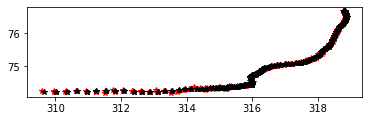

In [40]:
import matplotlib.pyplot as plt
data = data_argo_2['1448']['57']
data_gt = data_gt_argo_2['1448']['57']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()

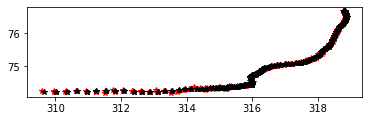

57(296, 2)
57(296, 2)


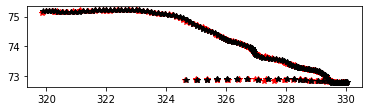

53(296, 2)
53(296, 2)


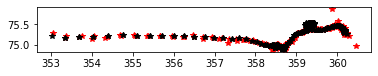

50(296, 2)
50(296, 2)


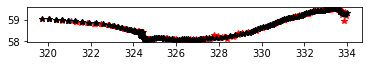

49(296, 2)
49(296, 2)


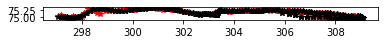

56(296, 2)
56(296, 2)


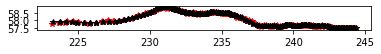

83(296, 2)
83(296, 2)


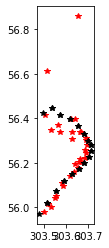

82(32, 2)
82(32, 2)


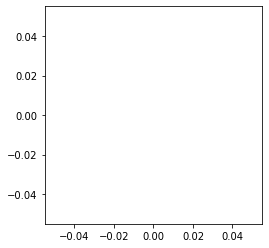

81(0, 2)
81(0, 2)


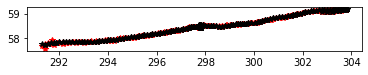

77(278, 2)
77(278, 2)


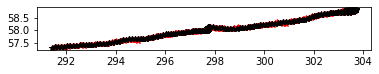

76(282, 2)
76(282, 2)


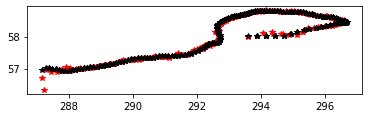

75(294, 2)
75(294, 2)


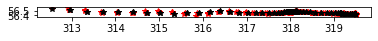

68(296, 2)
68(296, 2)


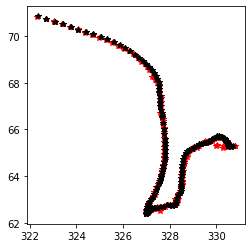

65(296, 2)
65(296, 2)


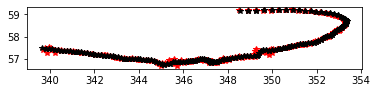

61(296, 2)
61(296, 2)


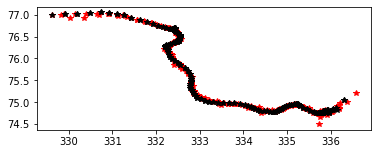

93(276, 2)
93(276, 2)


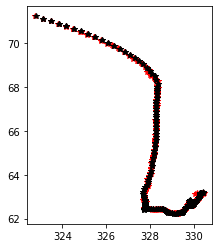

94(286, 2)
94(286, 2)


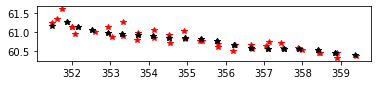

95(38, 2)
95(38, 2)


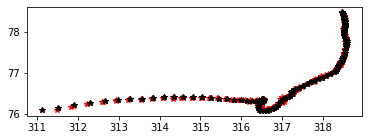

99(264, 2)
99(264, 2)


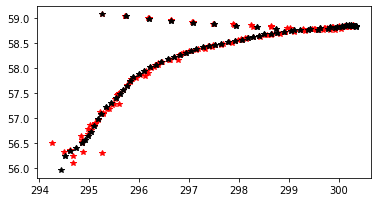

103(152, 2)
103(152, 2)


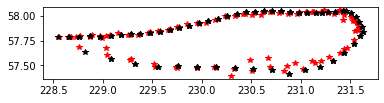

104(108, 2)
104(108, 2)


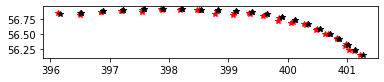

108(40, 2)
108(40, 2)


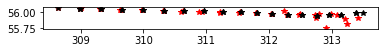

109(36, 2)
109(36, 2)


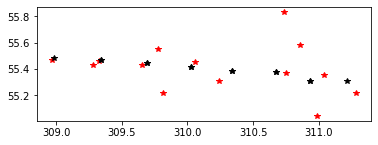

110(14, 2)
110(14, 2)


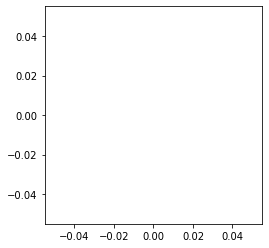

111(0, 2)
111(0, 2)


In [38]:
import matplotlib.pyplot as plt
scene = '1448'
for key in data_argo_2[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_argo_2[scene][key]
  data_gt = data_gt_argo_2[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


In [39]:
data_argo_4, data_gt_argo_4 = plot_trajectories('models/vel_ee', 12, './data/processed/Argoverse/Argoverse_1_full.pkl', 'PEDESTRIAN', 4)

 20%|██        | 4/20 [00:00<00:00, 27.75it/s]


Loading from models/vel_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/20 [00:00<?, ?it/s]

Prediction Horizon: 4
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


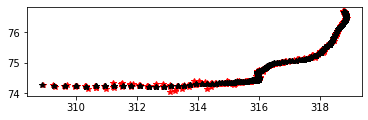

In [41]:
import matplotlib.pyplot as plt
data = data_argo_4['1448']['57']
data_gt = data_gt_argo_4['1448']['57']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()

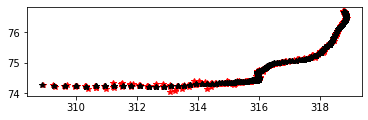

57(592, 2)
57(592, 2)


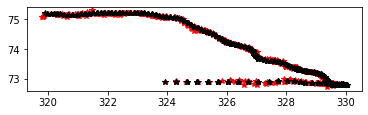

53(592, 2)
53(592, 2)


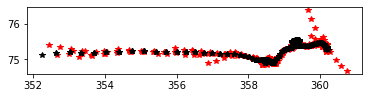

50(592, 2)
50(592, 2)


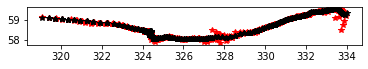

49(592, 2)
49(592, 2)


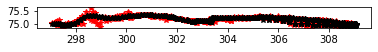

56(592, 2)
56(592, 2)


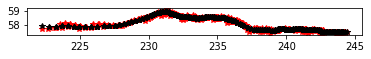

83(592, 2)
83(592, 2)


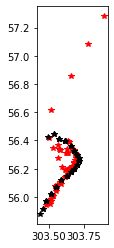

82(64, 2)
82(64, 2)


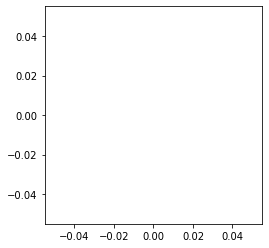

81(0, 2)
81(0, 2)


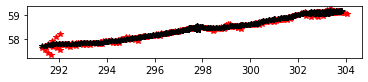

77(556, 2)
77(556, 2)


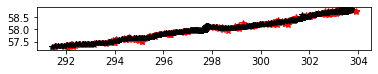

76(564, 2)
76(564, 2)


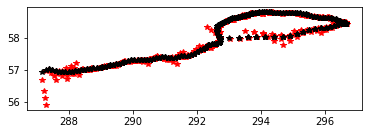

75(588, 2)
75(588, 2)


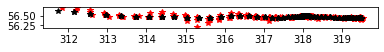

68(592, 2)
68(592, 2)


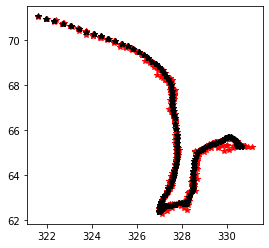

65(592, 2)
65(592, 2)


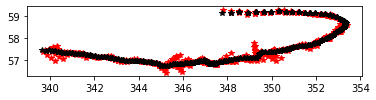

61(592, 2)
61(592, 2)


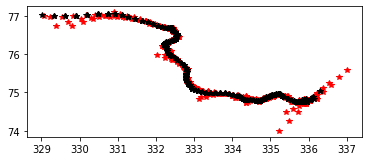

93(552, 2)
93(552, 2)


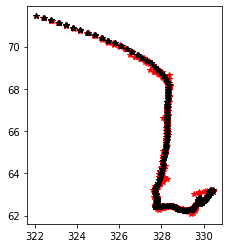

94(572, 2)
94(572, 2)


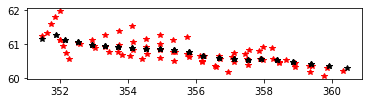

95(76, 2)
95(76, 2)


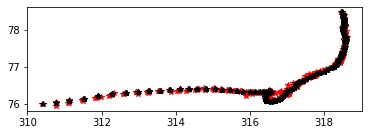

99(528, 2)
99(528, 2)


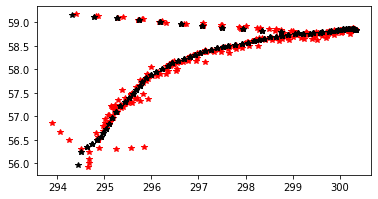

103(304, 2)
103(304, 2)


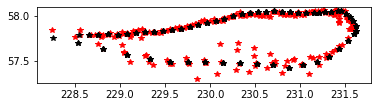

104(216, 2)
104(216, 2)


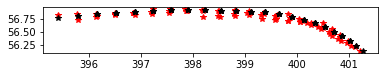

108(80, 2)
108(80, 2)


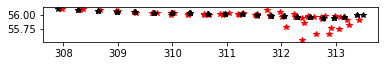

109(72, 2)
109(72, 2)


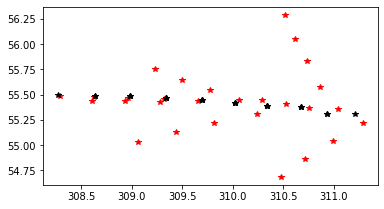

110(28, 2)
110(28, 2)


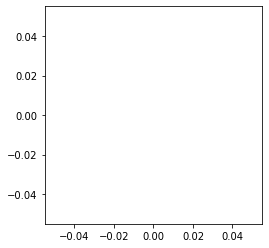

111(0, 2)
111(0, 2)


In [42]:
import matplotlib.pyplot as plt
scene = '1448'
for key in data_argo_4[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_argo_4[scene][key]
  data_gt = data_gt_argo_4[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


In [43]:
data_argo_6, data_gt_argo_6 = plot_trajectories('models/vel_ee', 12, './data/processed/Argoverse/Argoverse_1_full.pkl', 'PEDESTRIAN', 6)

 20%|██        | 4/20 [00:00<00:00, 26.39it/s]


Loading from models/vel_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/20 [00:00<?, ?it/s]

Prediction Horizon: 6
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


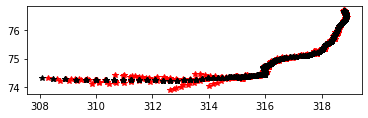

In [44]:
import matplotlib.pyplot as plt
data = data_argo_6['1448']['57']
data_gt = data_gt_argo_6['1448']['57']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()

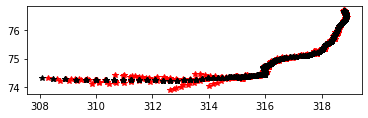

57(888, 2)
57(888, 2)


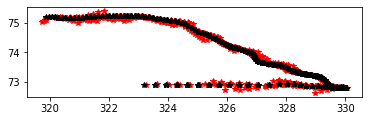

53(888, 2)
53(888, 2)


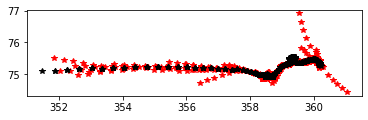

50(888, 2)
50(888, 2)


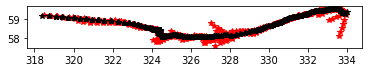

49(888, 2)
49(888, 2)


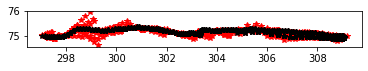

56(888, 2)
56(888, 2)


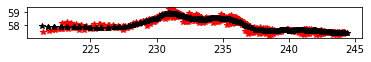

83(888, 2)
83(888, 2)


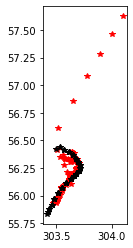

82(96, 2)
82(96, 2)


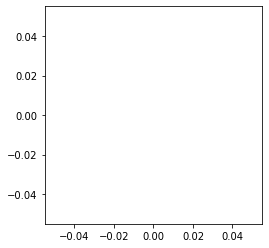

81(0, 2)
81(0, 2)


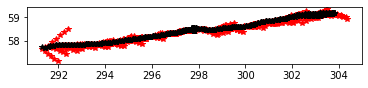

77(834, 2)
77(834, 2)


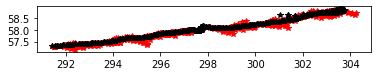

76(846, 2)
76(846, 2)


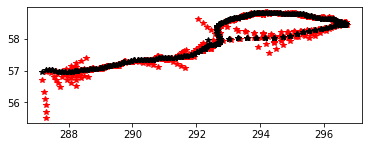

75(882, 2)
75(882, 2)


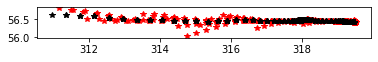

68(888, 2)
68(888, 2)


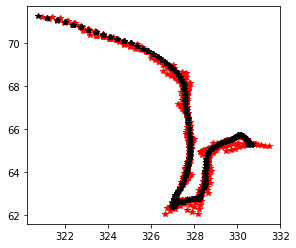

65(888, 2)
65(888, 2)


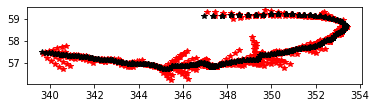

61(888, 2)
61(888, 2)


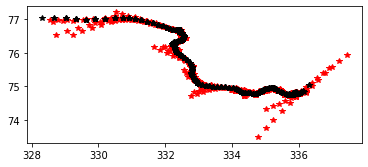

93(828, 2)
93(828, 2)


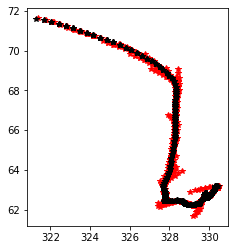

94(858, 2)
94(858, 2)


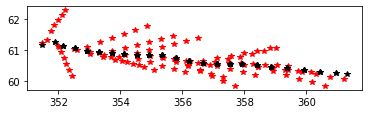

95(114, 2)
95(114, 2)


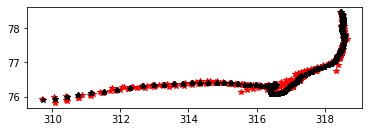

99(792, 2)
99(792, 2)


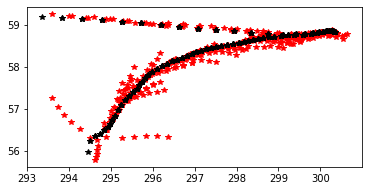

103(456, 2)
103(456, 2)


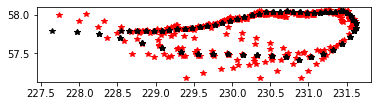

104(324, 2)
104(324, 2)


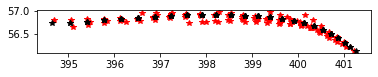

108(120, 2)
108(120, 2)


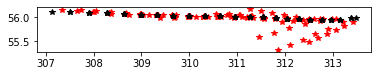

109(108, 2)
109(108, 2)


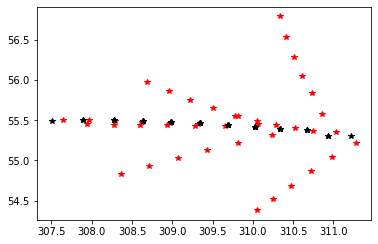

110(42, 2)
110(42, 2)


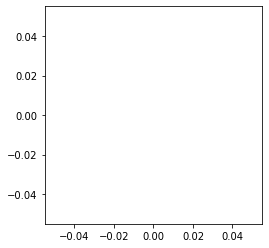

111(0, 2)
111(0, 2)


In [45]:
import matplotlib.pyplot as plt
scene = '1448'
for key in data_argo_6[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_argo_6[scene][key]
  data_gt = data_gt_argo_6[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


### Waymo (Done)


In [46]:
print_scene('./data/processed/Waymo/Waymo_0000_full.pkl')

850 Scene: Duration: 19.8s, Nodes: 17, Map: No.
851 Scene: Duration: 19.900000000000002s, Nodes: 1, Map: No.
852 Scene: Duration: 19.900000000000002s, Nodes: 18, Map: No.
853 Scene: Duration: 19.8s, Nodes: 16, Map: No.
854 Scene: Duration: 19.8s, Nodes: 40, Map: No.
855 Scene: Duration: 19.8s, Nodes: 3, Map: No.
856 Scene: Duration: 19.900000000000002s, Nodes: 20, Map: No.
857 Scene: Duration: 19.700000000000003s, Nodes: 13, Map: No.
858 Scene: Duration: 19.900000000000002s, Nodes: 46, Map: No.
859 Scene: Duration: 19.8s, Nodes: 7, Map: No.
860 Scene: Duration: 19.900000000000002s, Nodes: 13, Map: No.
861 Scene: Duration: 19.8s, Nodes: 12, Map: No.
862 Scene: Duration: 19.8s, Nodes: 6, Map: No.
863 Scene: Duration: 19.8s, Nodes: 34, Map: No.
864 Scene: Duration: 19.8s, Nodes: 5, Map: No.
865 Scene: Duration: 19.8s, Nodes: 13, Map: No.
866 Scene: Duration: 19.900000000000002s, Nodes: 1, Map: No.
867 Scene: Duration: 19.900000000000002s, Nodes: 11, Map: No.
868 Scene: Duration: 19.8s, No

In [47]:
data_waymo_2, data_gt_waymo_2 = plot_trajectories('models/vel_ee', 12, './data/processed/Waymo/Waymo_0000_full.pkl', 'PEDESTRIAN', 2)

 21%|██        | 5/24 [00:00<00:00, 31.49it/s]


Loading from models/vel_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/24 [00:00<?, ?it/s]

Prediction Horizon: 2
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 24/24 [00:58<00:00,  2.42s/it]


In [48]:
data_waymo_2.keys()
for key in data_waymo_2.keys():
  print(key + ' ' + str(data_waymo_2[key].keys()))

850 dict_keys([])
851 dict_keys([])
852 dict_keys([])
853 dict_keys([])
854 dict_keys([])
855 dict_keys([])
856 dict_keys([])
857 dict_keys([])
858 dict_keys([])
859 dict_keys([])
860 dict_keys([])
861 dict_keys([])
862 dict_keys([])
863 dict_keys([])
864 dict_keys(['87', '86', '91', '94'])
865 dict_keys([])
866 dict_keys([])
867 dict_keys([])
868 dict_keys([])
869 dict_keys([])
870 dict_keys([])
871 dict_keys([])
872 dict_keys([])
873 dict_keys(['65', '66', '67', '70', '69', '71', '72', '73', '74', '75', '76', '78', '77', '81', '82', '83', '87'])


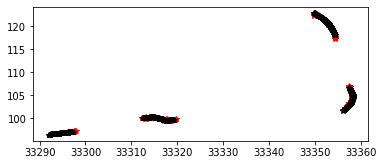

In [49]:
import matplotlib.pyplot as plt
data = data_waymo_2['873']['65']
data_gt = data_gt_waymo_2['873']['65']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()

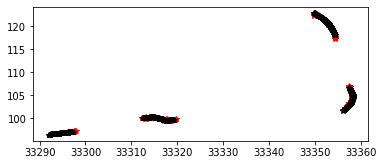

65(374, 2)
65(374, 2)


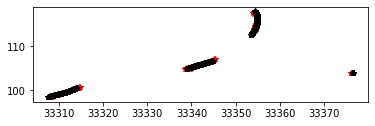

66(368, 2)
66(368, 2)


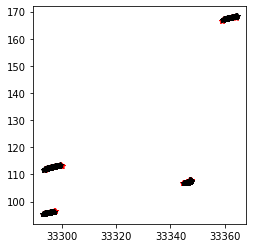

67(356, 2)
67(356, 2)


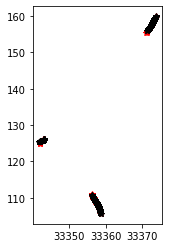

70(262, 2)
70(262, 2)


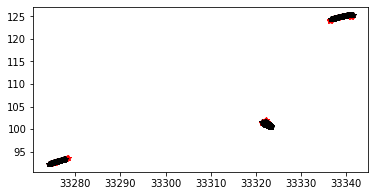

69(262, 2)
69(262, 2)


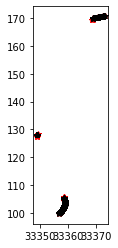

71(260, 2)
71(260, 2)


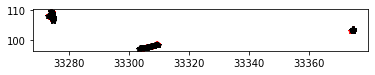

72(238, 2)
72(238, 2)


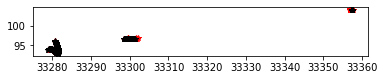

73(232, 2)
73(232, 2)


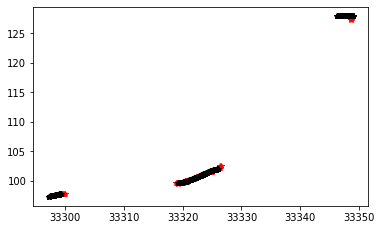

74(222, 2)
74(222, 2)


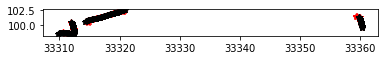

75(220, 2)
75(220, 2)


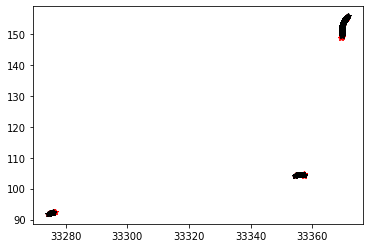

76(210, 2)
76(210, 2)


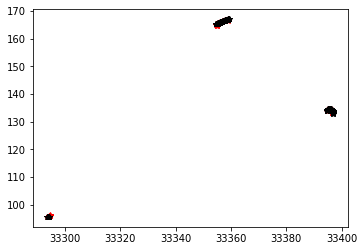

78(184, 2)
78(184, 2)


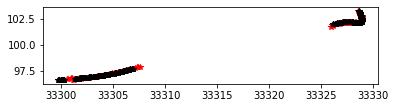

77(196, 2)
77(196, 2)


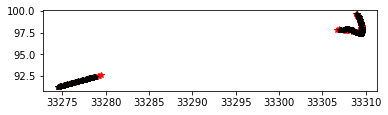

81(148, 2)
81(148, 2)


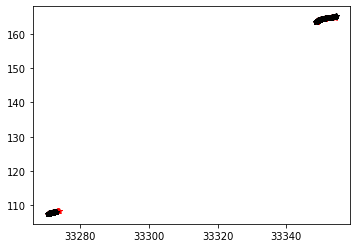

82(144, 2)
82(144, 2)


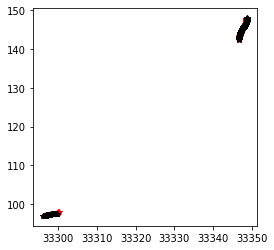

83(136, 2)
83(136, 2)


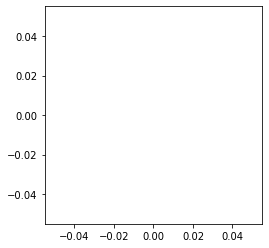

87(0, 2)
87(0, 2)


In [50]:
import matplotlib.pyplot as plt
scene = '873'
for key in data_waymo_2[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_waymo_2[scene][key]
  data_gt = data_gt_waymo_2[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


In [51]:
data_waymo_4, data_gt_waymo_4 = plot_trajectories('models/vel_ee', 12, './data/processed/Waymo/Waymo_0000_full.pkl', 'PEDESTRIAN', 4)

 21%|██        | 5/24 [00:00<00:00, 31.22it/s]


Loading from models/vel_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/24 [00:00<?, ?it/s]

Prediction Horizon: 4
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 24/24 [00:58<00:00,  2.45s/it]


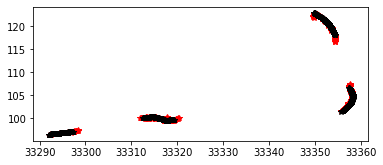

In [52]:
import matplotlib.pyplot as plt
data = data_waymo_4['873']['65']
data_gt = data_gt_waymo_4['873']['65']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()

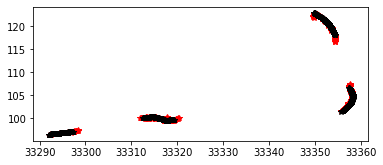

65(748, 2)
65(748, 2)


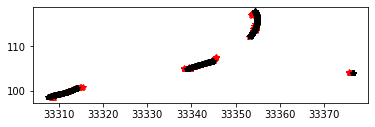

66(736, 2)
66(736, 2)


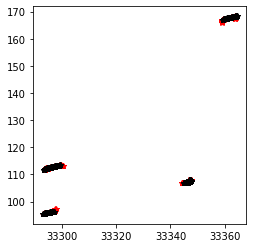

67(712, 2)
67(712, 2)


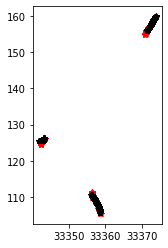

70(524, 2)
70(524, 2)


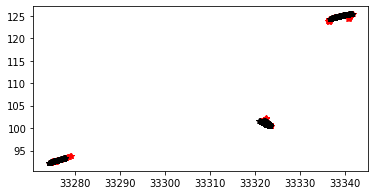

69(524, 2)
69(524, 2)


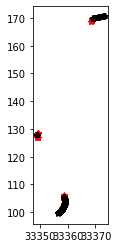

71(520, 2)
71(520, 2)


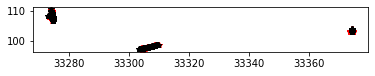

72(476, 2)
72(476, 2)


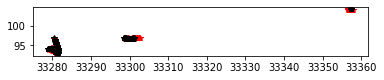

73(464, 2)
73(464, 2)


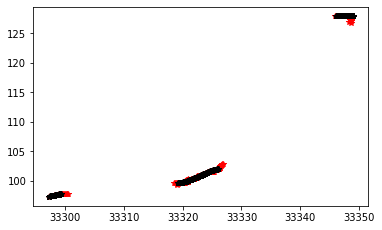

74(444, 2)
74(444, 2)


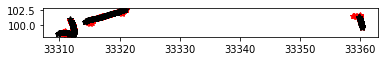

75(440, 2)
75(440, 2)


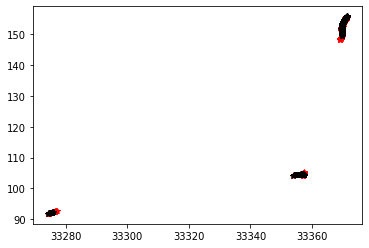

76(420, 2)
76(420, 2)


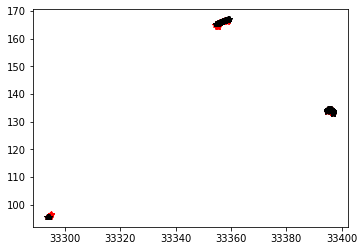

78(368, 2)
78(368, 2)


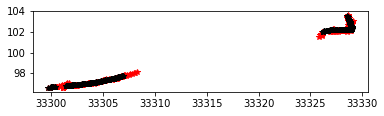

77(392, 2)
77(392, 2)


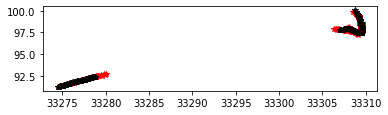

81(296, 2)
81(296, 2)


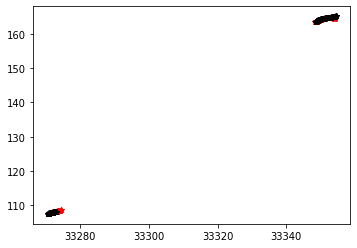

82(288, 2)
82(288, 2)


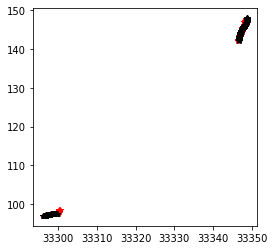

83(272, 2)
83(272, 2)


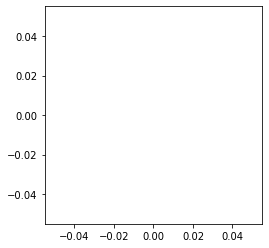

87(0, 2)
87(0, 2)


In [53]:
import matplotlib.pyplot as plt
scene = '873'
for key in data_waymo_4[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_waymo_4[scene][key]
  data_gt = data_gt_waymo_4[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))


In [54]:
data_waymo_6, data_gt_waymo_6 = plot_trajectories('models/vel_ee', 12, './data/processed/Waymo/Waymo_0000_full.pkl', 'PEDESTRIAN', 6)

 21%|██        | 5/24 [00:00<00:00, 29.72it/s]


Loading from models/vel_ee/model_registrar-12.pt
Loaded!

-- Preparing Node Graph


  0%|          | 0/24 [00:00<?, ?it/s]

Prediction Horizon: 6
-- Evaluating GMM Z Mode (Most Likely)


100%|██████████| 24/24 [00:59<00:00,  2.49s/it]


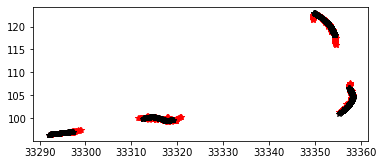

In [55]:
import matplotlib.pyplot as plt
data = data_waymo_6['873']['65']
data_gt = data_gt_waymo_6['873']['65']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(data[:,0], data[:,1], 'r*')
plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
ax.set_aspect('equal', adjustable='box')
plt.show()

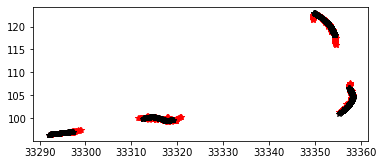

65(1122, 2)
65(1122, 2)


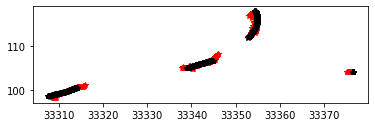

66(1104, 2)
66(1104, 2)


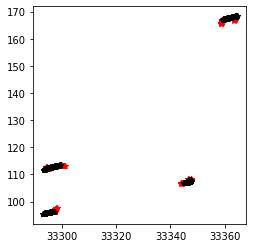

67(1068, 2)
67(1068, 2)


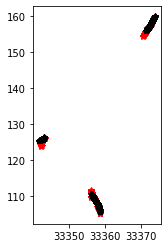

70(786, 2)
70(786, 2)


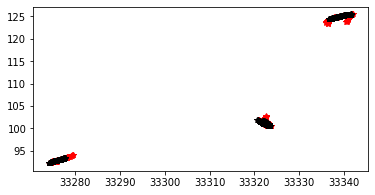

69(786, 2)
69(786, 2)


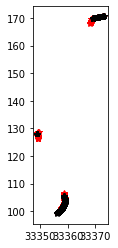

71(780, 2)
71(780, 2)


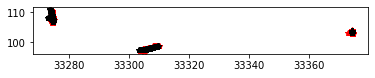

72(714, 2)
72(714, 2)


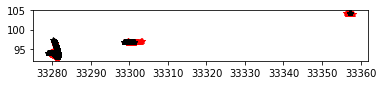

73(696, 2)
73(696, 2)


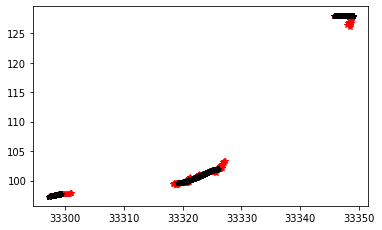

74(666, 2)
74(666, 2)


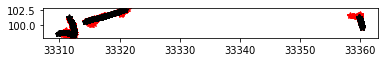

75(660, 2)
75(660, 2)


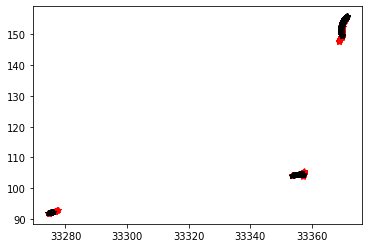

76(630, 2)
76(630, 2)


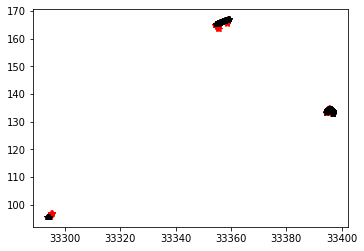

78(552, 2)
78(552, 2)


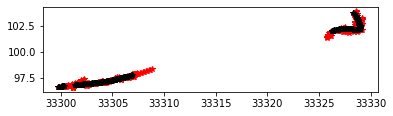

77(588, 2)
77(588, 2)


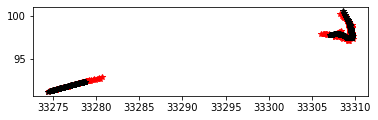

81(444, 2)
81(444, 2)


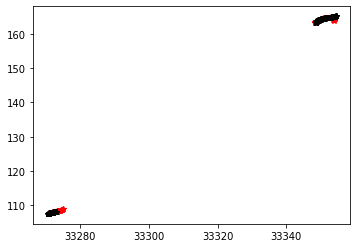

82(432, 2)
82(432, 2)


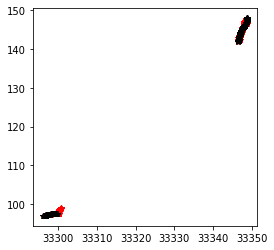

83(408, 2)
83(408, 2)


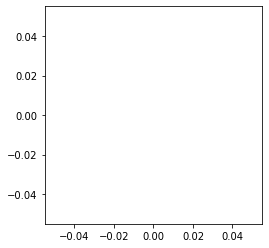

87(0, 2)
87(0, 2)


In [56]:
import matplotlib.pyplot as plt
scene = '873'
for key in data_waymo_6[scene].keys():
  fig = plt.figure()
  ax = fig.add_subplot(111)
  data = data_waymo_6[scene][key]
  data_gt = data_gt_waymo_6[scene][key]
  plt.plot(data[:,0], data[:,1], 'r*')
  plt.plot(data_gt[:,0], data_gt[:,1], 'k*')
  ax.set_aspect('equal', adjustable='box')
  plt.show()
  print(str(key) + str(data.shape))
  print(str(key) + str(data_gt.shape))
